<a href="https://colab.research.google.com/github/katterine2558/mri-tumor-detection-cnn/blob/main/pretrained_mri_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================================
# 🔧 CONFIGURACIÓN DE ENTORNO COLAB PRO (GPU + OPTIMIZACIONES)
# ==========================================================
import os, gc, psutil, tensorflow as tf
from tensorflow.keras import mixed_precision

# ----------------------------------------------------------
# 1️⃣ LIMPIEZA DE SESIÓN ANTERIOR
# ----------------------------------------------------------
gc.collect()
tf.keras.backend.clear_session()

# ----------------------------------------------------------
# 2️⃣ INFORMACIÓN DEL HARDWARE
# ----------------------------------------------------------
try:
    gpu_info = !nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
    print("GPU detectada:", gpu_info[0])
except:
    print("No se detectó GPU, verifica que el acelerador esté activado en Entorno > Configuración de ejecución.")

# ----------------------------------------------------------
# 3️⃣ FORZAR USO DE GPU
# ----------------------------------------------------------
physical_gpus = tf.config.list_physical_devices('GPU')
if physical_gpus:
    print(f"TensorFlow detecta {len(physical_gpus)} GPU(s): {physical_gpus}")
    try:
        for gpu in physical_gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass
else:
    print("No hay GPU activa, se usará CPU (entrenamiento más lento).")

# ----------------------------------------------------------
# 4️⃣ ACTIVAR ENTRENAMIENTO DE PRECISIÓN MIXTA (FLOAT16)
# ----------------------------------------------------------
mixed_precision.set_global_policy('mixed_float16')
print("Política de precisión:", mixed_precision.global_policy())

# ----------------------------------------------------------
# 6️⃣ MOSTRAR INFORMACIÓN DE RECURSOS
# ----------------------------------------------------------
print(f"Memoria RAM disponible: {psutil.virtual_memory().total / 1e9:.2f} GB")
print("Entorno configurado correctamente para máximo rendimiento.\n")

GPU detectada: Tesla T4, 15360 MiB
TensorFlow detecta 1 GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Política de precisión: <DTypePolicy "mixed_float16">
Memoria RAM disponible: 54.75 GB
Entorno configurado correctamente para máximo rendimiento.



In [2]:
#==========================================================
# LIBRARIES
#==========================================================
from google.colab import files
#!pip install -q kaggle #Descomentar si no está instalado Kaggle en el entorno
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import Counter
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Add, Activation,GlobalAveragePooling2D , Multiply, Reshape, DepthwiseConv2D, BatchNormalization ,GlobalAveragePooling2D, Resizing, Rescaling, RandomBrightness, RandomContrast, RandomRotation, RandomZoom, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import AUC
!pip install keras-tuner --upgrade
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
!nvidia-smi

#Ruta base
base_dir = '/content/mri_data'
#Ruta para almacenar split
split_dir = "/content/mri_data_split"
#Semilla
seed = 0;
#Tamaño del batch
batch_size = 128
#Image size
image_size = (224, 224)

print("Dispositivo:", tf.config.list_physical_devices('GPU'))
mixed_precision.set_global_policy('mixed_float16')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.debugging.set_log_device_placement(False)

# Carpeta donde guardas los resultados
tuner_dir = "tuning_results"

# Elimina la carpeta completa si existe
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00
Mon Nov  3 11:04:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                 

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 72% 171M/236M [00:00<00:00, 1.78GB/s]
100% 236M/236M [00:00<00:00, 1.81GB/s]
Categorías encontradas: ['meningioma', 'healthy', 'glioma', 'pituitary']
meningioma: 1645 imágenes
healthy: 2000 imágenes
glioma: 1621 imágenes
pituitary: 1757 imágenes


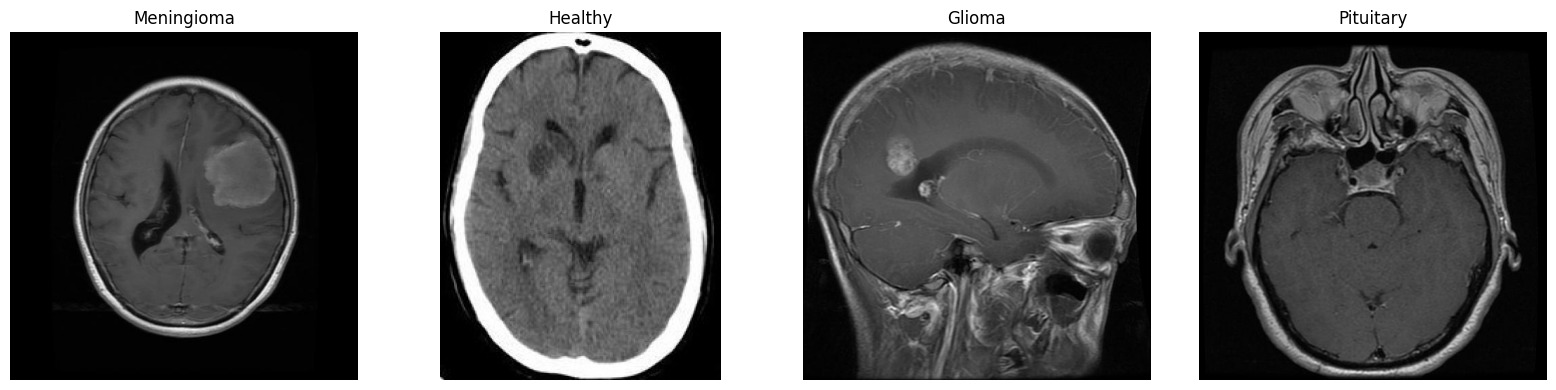

In [3]:
#==========================================================
# DOWNLOAD DATASET
#==========================================================
def download_mri_data(base_dir:str):

  files.upload() #APIKey de Kaggle

  !mkdir -p ~/.kaggle
  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Descargar el dataset
  !mkdir -p /content/mri_data
  !kaggle datasets download -d rm1000/brain-tumor-mri-scans -p /content/mri_data --unzip

  # Listar categorías
  categories = os.listdir(base_dir)
  print("Categorías encontradas:", categories)

  # Contar imágenes por clase
  for c in categories:
      path = os.path.join(base_dir, c)
      print(f"{c}: {len(os.listdir(path))} imágenes")

  fig, axes = plt.subplots(1, 4, figsize=(16, 4))
  for i, c in enumerate(categories):
      folder = os.path.join(base_dir, c)
      img_name = random.choice(os.listdir(folder))
      img_path = os.path.join(folder, img_name)
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[i].imshow(img)
      axes[i].set_title(c.capitalize())
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

#Descarga el conjunto de datos
download_mri_data(base_dir)

In [4]:
#==========================================================
# IMAGE SIZE SCANNER
#==========================================================

def get_images_size(base_dir:str):

  all_sizes = []  # guardamos (ancho, alto)
  per_class_count = {}

  for cls in os.listdir(base_dir):
      cls_path = os.path.join(base_dir, cls)
      if not os.path.isdir(cls_path):
          continue

      imgs = os.listdir(cls_path)
      per_class_count[cls] = len(imgs)

      # vamos a mirar hasta 20 imágenes por clase (para no leer miles)
      for img_name in imgs[:20]:
          img_path = os.path.join(cls_path, img_name)
          img = cv2.imread(img_path)  # esto lee en BGR
          if img is None:
              # a veces hay archivos raros tipo .txt o corruptos
              continue
          h, w, ch = img.shape  # alto, ancho, canales
          all_sizes.append((w, h, ch))


  print("\nEjemplos de tamaños (ancho x alto x canales) en las primeras imágenes revisadas:")
  for s in all_sizes[:10]:
      print(" ", s)

  # estadísticas más globales
  widths = [s[0] for s in all_sizes]
  heights = [s[1] for s in all_sizes]
  channels = [s[2] for s in all_sizes]

  print("\nEstadísticas:")
  print(f"  Ancho min / max / promedio: {min(widths)} / {max(widths)} / {np.mean(widths):.1f}")
  print(f"  Alto  min / max / promedio: {min(heights)} / {max(heights)} / {np.mean(heights):.1f}")

  print("\nCanales más comunes (1=gris, 3=RGB):")
  print(Counter(channels))

#Obtiene el tamaño de las imágenes
get_images_size(base_dir)


Ejemplos de tamaños (ancho x alto x canales) en las primeras imágenes revisadas:
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)
  (512, 512, 3)

Estadísticas:
  Ancho min / max / promedio: 206 / 630 / 461.6
  Alto  min / max / promedio: 214 / 630 / 462.8

Canales más comunes (1=gris, 3=RGB):
Counter({3: 80})


In [5]:
# ==========================================================
# TRAIN-VAL-TEST DIVISION (70-20-10)
# ==========================================================

def traint_val_test_split(base_dir:str, split_dir:str):
    # Crear carpetas destino
    for split in ['train', 'val', 'test']:
        for cls in os.listdir(base_dir):
            os.makedirs(os.path.join(split_dir, split, cls), exist_ok=True)

    # Ratios
    train_ratio = 0.7
    val_ratio = 0.2
    test_ratio = 0.1

    # Procesar cada clase
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]

        # Dividir train / val / test
        train_files, temp_files = train_test_split(images, test_size=(1-train_ratio), random_state=seed)
        val_size = val_ratio / (val_ratio + test_ratio)
        val_files, test_files = train_test_split(temp_files, test_size=(1-val_size), random_state=seed)

        # Copiar archivos
        for fname in train_files:
            shutil.copy(os.path.join(cls_path, fname), os.path.join(split_dir, 'train', cls, fname))
        for fname in val_files:
            shutil.copy(os.path.join(cls_path, fname), os.path.join(split_dir, 'val', cls, fname))
        for fname in test_files:
            shutil.copy(os.path.join(cls_path, fname), os.path.join(split_dir, 'test', cls, fname))

    print("División completada con semilla =", seed)
    print("Estructura creada en:", split_dir)

    for split in ['train', 'val', 'test']:
        print(f"\n * {split.upper()}")
        for cls in os.listdir(os.path.join(split_dir, split)):
            count = len(os.listdir(os.path.join(split_dir, split, cls)))
            print(f"  {cls}: {count} imágenes")


# Ejecutar división solo una vez
traint_val_test_split(base_dir, split_dir)

# ==========================================================
# CARGA DE LOS DATASETS
# ==========================================================
train_ds_raw= tf.keras.utils.image_dataset_from_directory(
        f'{split_dir}/train',
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        image_size=image_size
    )

val_ds_raw= tf.keras.utils.image_dataset_from_directory(
        f'{split_dir}/val',
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        image_size=image_size
    )

test_ds_raw= tf.keras.utils.image_dataset_from_directory(
        f'{split_dir}/test',
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        image_size=image_size
    )

AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, batch_size=32, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds_raw, shuffle=True)
val_ds   = prepare_dataset(val_ds_raw)
test_ds  = prepare_dataset(test_ds_raw)

División completada con semilla = 0
Estructura creada en: /content/mri_data_split

 * TRAIN
  meningioma: 1151 imágenes
  healthy: 1399 imágenes
  glioma: 1134 imágenes
  pituitary: 1229 imágenes

 * VAL
  meningioma: 329 imágenes
  healthy: 400 imágenes
  glioma: 324 imágenes
  pituitary: 351 imágenes

 * TEST
  meningioma: 165 imágenes
  healthy: 201 imágenes
  glioma: 163 imágenes
  pituitary: 177 imágenes
Found 4913 files belonging to 4 classes.
Found 1404 files belonging to 4 classes.
Found 706 files belonging to 4 classes.


Found 4913 files belonging to 4 classes.
Clases detectadas: ['glioma', 'healthy', 'meningioma', 'pituitary']

Mapeo de etiquetas:
0 → glioma
1 → healthy
2 → meningioma
3 → pituitary

 Data augmentation aplicada al conjunto de entrenamiento.


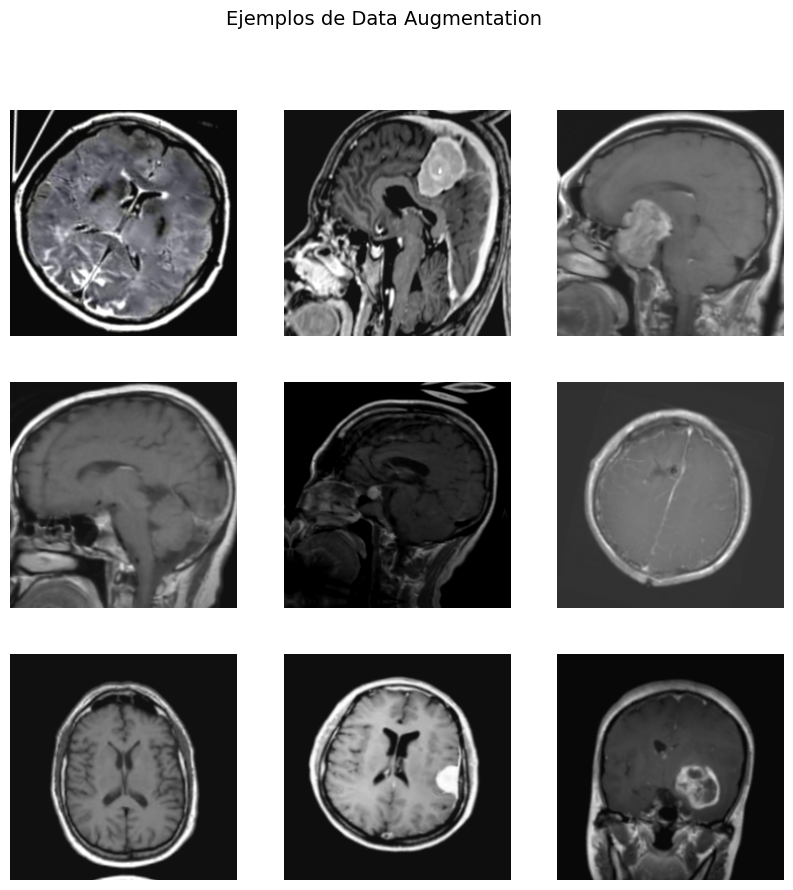

In [6]:
# ==========================================================
# TRAIN DATA AUGMENTATION
# ==========================================================

def data_augmentation(split_dir:str, seed:int, batch_size:int, image_size:tuple):
    # Cargar imágenes (se necesita tamaño fijo)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        f'{split_dir}/train',
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        image_size=image_size
    )

    class_names = train_ds.class_names
    print("Clases detectadas:", class_names)

    # 🔹 Crear mapeo explícito de índice → nombre
    label_map = {i: name for i, name in enumerate(class_names)}
    print("\nMapeo de etiquetas:")
    for key, value in label_map.items():
        print(f"{key} → {value}")

    # Definir Data Augmentation
    data_augmentation = tf.keras.Sequential([
        RandomRotation(0.05),
        RandomZoom(0.1),
        RandomContrast(0.1),
        RandomBrightness(0.1),
    ])

    # Aplicar aumentación
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    print("\n Data augmentation aplicada al conjunto de entrenamiento.")
    return train_ds, data_augmentation, class_names, label_map


def plot_data_augmentation(train_ds, data_augmentation):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(9):
            augmented = data_augmentation(images, training=True)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented[i].numpy().astype("uint8"))
            plt.axis("off")
        plt.suptitle("Ejemplos de Data Augmentation", fontsize=14)
        plt.show()
        break


# Ejecutar data augmentation
train_ds, data_aug, class_names, label_map = data_augmentation(split_dir, seed, batch_size, image_size)
plot_data_augmentation(train_ds, data_aug)


Shape de las imágenes: (128, 224, 224, 3)


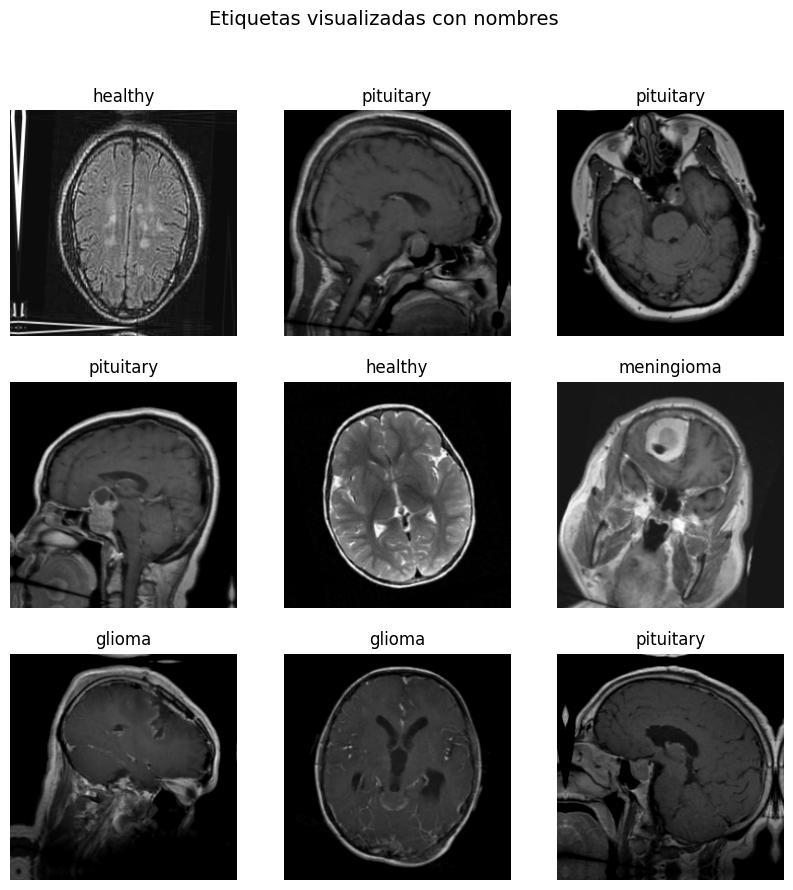

In [7]:
# ==========================================================
# TRAIN LABEL VERIFICATION
# ==========================================================

def get_label(train_ds, class_names, label_map):

    # Mostrar forma y etiquetas del primer batch
    for images, labels in train_ds.take(1):
        print("\nShape de las imágenes:", images.shape)

        # Mostrar 9 imágenes con sus nombres de clase
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_idx = labels[i].numpy()
            plt.title(label_map[label_idx])
            plt.axis("off")
        plt.suptitle("Etiquetas visualizadas con nombres", fontsize=14)
        plt.show()
        break


# Ejecutar
get_label(train_ds, class_names, label_map)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0_MRI"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


🔹 Entrenando solo la cabeza del modelo (fase 1)...
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.6514 - loss: 0.8263 - val_accuracy: 0.7564 - val_loss: 0.6500
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8563 - loss: 0.3816 - val_accuracy: 0.8134 - val_loss: 0.5060
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8837 - loss: 0.3161 - val_accuracy: 0.8191 - val_loss: 0.5086
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8951 - loss: 0.2868 - val_accuracy: 0.8056 - val_loss: 0.5468
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9022 - loss: 0.2672 - val_accuracy: 0.8611 - val_loss: 0.3976
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9096 - loss: 0.2461 - val_accuracy: 0.8647 - val_loss: 0.3688
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9226 - loss: 0.2229 - val_accuracy: 0.8796 - val_loss: 0.3304
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9

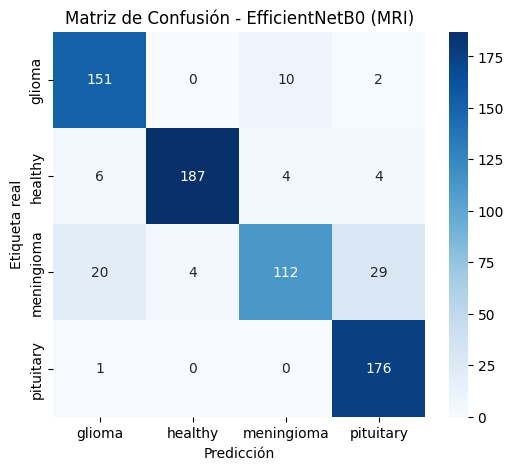

In [8]:
# ==========================================================
# 🧠 MODELO PREENTRENADO: EfficientNetB0 (TRANSFER LEARNING)
# ==========================================================
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Base preentrenada
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # fase 1: congelada

# Cabeza personalizada (clasificador)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="swish")(x)
x = Dropout(0.4)(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs, name="EfficientNetB0_MRI")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

model.summary()

# ==========================================================
# ENTRENAMIENTO FASE 1 (CABEZA CONGELADA)
# ==========================================================
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("\n🔹 Entrenando solo la cabeza del modelo (fase 1)...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

# ==========================================================
# FINE-TUNING FASE 2 (DESCONGELAR PARCIALMENTE)
# ==========================================================
base_model.trainable = True

fine_tune_at = 200  # descongela desde esta capa
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

print("\n🔹 Fine-tuning (fase 2)...")
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

# ==========================================================
# EVALUACIÓN FINAL
# ==========================================================
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

# ==========================================================
# REPORTE DE CLASIFICACIÓN Y MATRIZ DE CONFUSIÓN
# ==========================================================
y_true, y_pred = [], []
for x, y in test_ds:
    preds = np.argmax(model.predict(x), axis=1)
    y_true.extend(y.numpy())
    y_pred.extend(preds)

print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=train_ds_raw.class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds_raw.class_names,
            yticklabels=train_ds_raw.class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión - EfficientNetB0 (MRI)")
plt.show()